#### 1. Importando as bibliotecas 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Realizando a leitura do arquivo e criando o dataset 

In [2]:
# Definindo uma variável com o caminho para os arquivos JSON
path = os.getcwd() + '\\JSON'

# Realizando a leitura do arquivo "business.json" e criando o dataset
business = pd.read_json(path + '\\business.json', lines=True)

# Exibindo as primeiras linhas do dataset para confirmar se o arquivo foi lido corretamente
business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


#### 3. EDA

In [3]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


* Observa-se que cada linha desse dataset contém informações referentes à um negócio único (150.346 negócios cadastrados).

* Nota-se a presença de valores faltantes nas 3 últimas features do dataset (attributes, categories e hours). Tratarei dessa questão posteriormente.

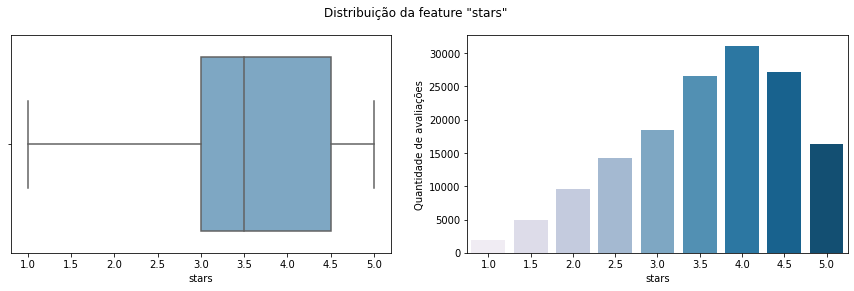

In [4]:
# Verificando a distribuição da feature 'stars' (que será o target do nosso futuro modelo)

stars = business['stars'].agg('value_counts')

fig, ax = plt.subplots(1,2, figsize=[15,4])

sns.boxplot(ax=ax[0],
            data=business,
            x='stars',
            palette='PuBu'
           )

sns.barplot(ax=ax[1],
            x=stars.index,
            y=stars,
            palette='PuBu'
           )

fig.suptitle('Distribuição da feature "stars"')
ax[1].set_xlabel('stars')
ax[1].set_ylabel('Quantidade de avaliações')
plt.show()

In [5]:
business['stars'].describe()

count    150346.000000
mean          3.596724
std           0.974421
min           1.000000
25%           3.000000
50%           3.500000
75%           4.500000
max           5.000000
Name: stars, dtype: float64

In [9]:
# Criando um Dataframe contendo a quantidade total de negócios (abertos e fechados) agrupados por Estado

df_total_business = business[['state','is_open']].groupby('state').sum()
df_total_business['total'] = business[['state','is_open']].groupby('state').count()
df_total_business = df_total_business.sort_values(by='total', ascending=False).reset_index()
df_total_business.head()

,state,is_open,total
0,PA,26289,34039
1,FL,21540,26330
2,TN,9600,12056
3,IN,8946,11247
4,MO,8363,10913


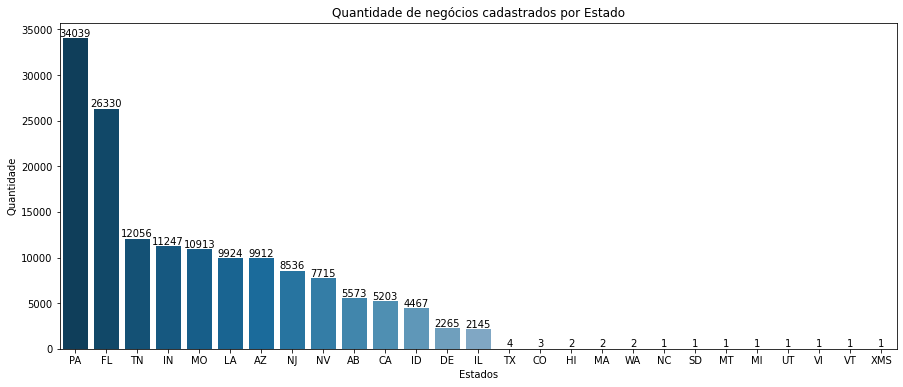

In [10]:
# Verificando os Estados que possuem a maior quantidade de negócios cadastrados

fig, ax = plt.subplots(figsize=[15,6])

ax = sns.barplot(x=df_total_business['state'],
                 y=df_total_business['total'],
                 palette='PuBu_r'
                )
for i in ax.containers:
    ax.bar_label(i,)

ax.set(xlabel='Estados',
       ylabel='Quantidade',
       title='Quantidade de negócios cadastrados por Estado'
      )
plt.show()

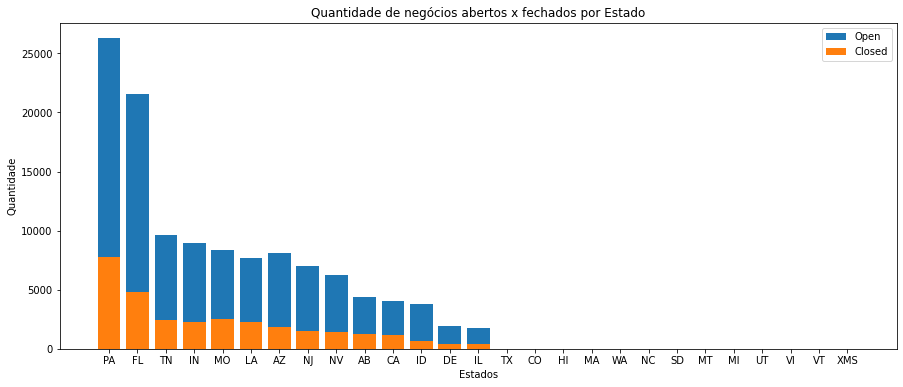

In [11]:
# Verificando a diferença entre negócios abertos x fechados por Estado

fig, ax = plt.subplots(figsize=[15,6])

plt.bar(x=df_total_business['state'], height=df_total_business['is_open'])
plt.bar(x=df_total_business['state'], height=(df_total_business['total'] - df_total_business['is_open']))

ax.set(xlabel='Estados',
       ylabel='Quantidade',
       title='Quantidade de negócios abertos x fechados por Estado'
      )
      
plt.legend(['Open','Closed'])
plt.show()

#### 4. Feature Engineering

* Realizando o tratamento da feature 'CATEGORIES'

In [12]:
# Classificando as categorias nulas como 'Unknown'

business["categories"].fillna(value='Unknown', inplace=True)

In [13]:
# Verificando o total de categorias ÚNICAS cadastradas

business["categories"].nunique()

83161

Cada linha contém várias categorias, separadas por vírgula e em formato string, associadas a um negócio único.

Por esse motivo observamos uma quantidade tão elevada de categorias únicas presentes nessa feature (83.161).

In [14]:
print(f'Conteúdo da variável: ', business['categories'][0])
print(f'Tipo da variáveL: ', type(business['categories'][0]))

Conteúdo da variável:  Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists
Tipo da variáveL:  <class 'str'>


In [15]:
# Verificando as top 10 categorias que possuem mais negócios cadastrados

business['categories'].value_counts().head(10)

Beauty & Spas, Nail Salons    1012
Restaurants, Pizza             935
Nail Salons, Beauty & Spas     934
Pizza, Restaurants             823
Restaurants, Mexican           728
Restaurants, Chinese           708
Mexican, Restaurants           672
Chinese, Restaurants           651
Food, Coffee & Tea             508
Beauty & Spas, Hair Salons     493
Name: categories, dtype: int64

Podemos notar que existem inconsistências como 'Restaurants, Mexican' e 'Mexican, Restaurants' sendo identificados como categorias únicas.

Utilizei o código abaixo para "desmembrar" as strings e extrair apenas as categorias únicas.

Em seguida resolvi atribuir números a cada uma das categorias únicas identificadas anteriormente e assim consegui minimizar o problema da "duplicidade" dos dados:

Exemplo:

'Restaurants, Mexican' recebe os valores 8 e 20 respectivamente. Quando somados resulta em 28.

'Mexican, Restaurants' recebe os valores 20 e 8 respectivamente. Quando somados também resulta em 28.

Dessa forma ambos serão classificados como uma única categoria.

In [58]:
unique_categs = [] #Lista que irá conter as categorias únicas
categ_num_list = [] #Lista que irá conter as categorias transformadas em inteiros

# Percorrendo cada valor da coluna 'categories'
for categ in business['categories']:
    # Por se tratar de uma única string com valores separados por vírgula
    # utilizei o método split para separar as palavras e gerar uma lista
    categ = categ.split(',')
    # Definindo a variável responsável por armazenar a soma dos valores
    # atribuídos a cada categoria 
    categ_num = 0
    # Percorrendo a lista gerada pelo comando 'split'
    for i in categ:
        # Removendo os espaços de cada valor
        i = i.replace(' ','')
        # Verificando se o valor não se encontra na lista 'unique_categs'
        # e apendando à lista caso a condição seja satisfeita
        if i not in unique_categs:
            unique_categs.append(i)
        # Realizando a soma dos valores de cada categoria baseado no índice das mesmas
        categ_num += unique_categs.index(i)
    # Apendando na lista 'categ_num_list'   
    categ_num_list.append(categ_num)

# Incorporando os novos valores ao dataset
business['categ_num'] = categ_num_list

In [60]:
# Verificando novamente o total de categorias ÚNICAS cadastradas após os tratamentos realizados no passo anterior

business['categ_num'].nunique()

4008

In [61]:
# Exibindo algumas das categorias ÚNICAS extraídas

unique_categs[:10]

['Doctors',
 'TraditionalChineseMedicine',
 'Naturopathic/Holistic',
 'Acupuncture',
 'Health&Medical',
 'Nutritionists',
 'ShippingCenters',
 'LocalServices',
 'Notaries',
 'MailboxCenters']

* Realizando o tratamento da feature 'ATTRIBUTES'

In [62]:
# Classificando os atributos nulos como 'Unknown'

business["attributes"].fillna(value='Unknown', inplace=True)

Cada linha contém vários atributos no formato de dicionário, associados a um negócio único.

In [65]:
print(f'Conteúdo da variável: ', business['attributes'][3])
print(f'Tipo da variáveL: ', type(business['attributes'][3]))

Conteúdo da variável:  {'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'BikeParking': 'True', 'RestaurantsPriceRange2': '1', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False', 'WiFi': "u'free'", 'Alcohol': "u'none'", 'Caters': 'True'}
Tipo da variáveL:  <class 'dict'>


In [84]:
# Extraindo cada um dos atributos para verificar sua quantidade real

unique_attributes = []

# Percorrendo cada valor da coluna 'attributes'
for attribute in business['attributes']:
    # Observando apenas valores válidos
    if attribute != 'Unknown':
        for key in attribute.keys():
            # Verificando se o valor não se encontra na lista unique_attributes
            if key not in unique_attributes:
                unique_attributes.append(key)

In [85]:
len(unique_attributes)

39

Próxima etapa do tratamento da feature 'ATTRIBUTES' está em desenvolvimento.. trago atualizações em breve!

12/12/2022